In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from DataLoader.my_dataloader import get_loader
from DCNN.model import Model_sep, Model, Ensemble
import torch
import torch.nn as nn
from data.prepare_data import get_data_paths, read_CT_scans, missing_PTVs, read_data, read_all_data, delete_duplication, read_masks
import sklearn.metrics
import os
import seaborn as sns
import os


In [2]:
train, val, test = get_loader('data', train_bs=32,
        val_bs=1,
        test_bs=1,
        train_num_samples_per_epoch=7800,  # 5000 iterations per epoch
        val_num_samples_per_epoch=1200,
        test_num_samples_per_epoch=1200,
        num_works=1,
        resplit=False,
        seed=199,#199
        with_miss_PTVs=True,
        with_distance=True
    )



### Data Visualization

In [3]:
plt.rcParams["savefig.bbox"] = 'tight'

def show(data, predicted=None):
    CT_scan = data[0][0,2]
    PTVs = data[0][0,0]
    OARs = data[0][0,1]
    Rdose = data[1][0,0]
    distance_image = data[0][0,3]
    if predicted is None: a=5 
    else: a=7
    fig, axs = plt.subplots(ncols=a, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    
    axs[0, 0].set_title("CT scan")
    axs[0, 0].imshow(CT_scan, cmap='gray')

    axs[0, 1].set_title("PTVs")
    axs[0, 1].imshow(PTVs, cmap='jet')

    axs[0, 2].set_title("Distance transform")
    axs[0, 2].imshow(distance_image, cmap='jet')

    axs[0, 3].set_title("OARs")
    axs[0, 3].imshow(OARs, cmap='jet')

    axs[0, 4].set_title("Radiation dose")
    axs[0, 4].imshow(Rdose, cmap='jet')

    

    if predicted is not None:
        axs[0, 5].set_title("predicted Radiation dose")
        axs[0, 5].imshow(predicted, cmap='jet')

        axs[0, 6].set_title("Difference")
        axs[0, 6].imshow(np.abs(predicted - Rdose), cmap='jet')
    plt.show()



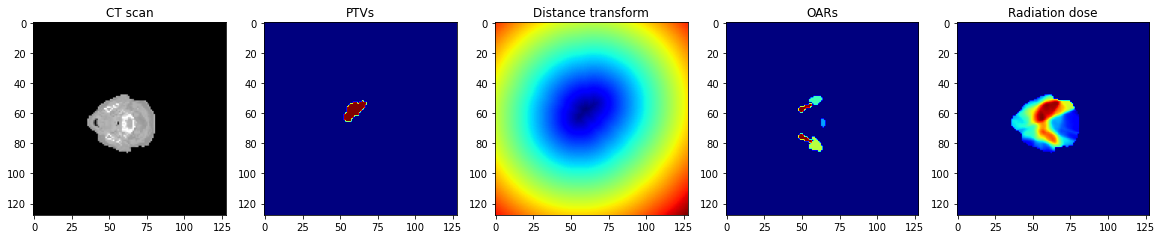

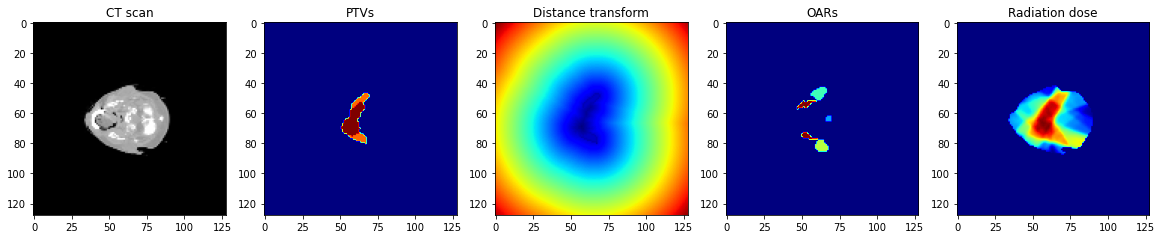

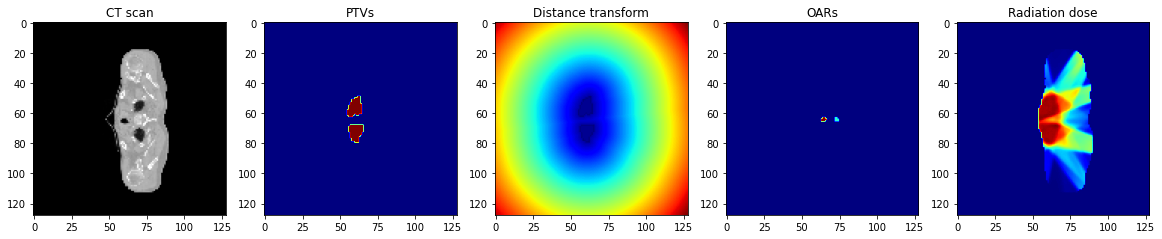

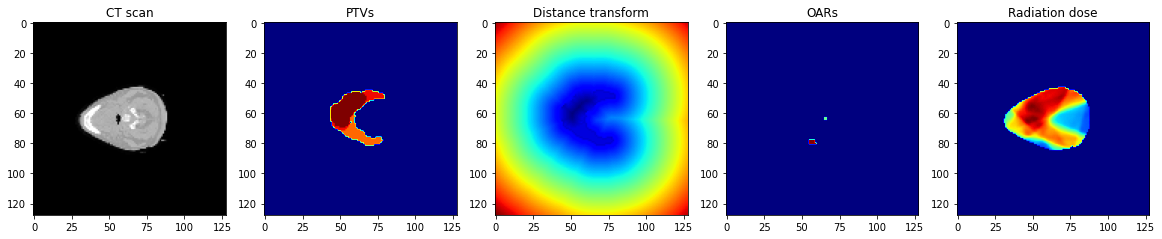

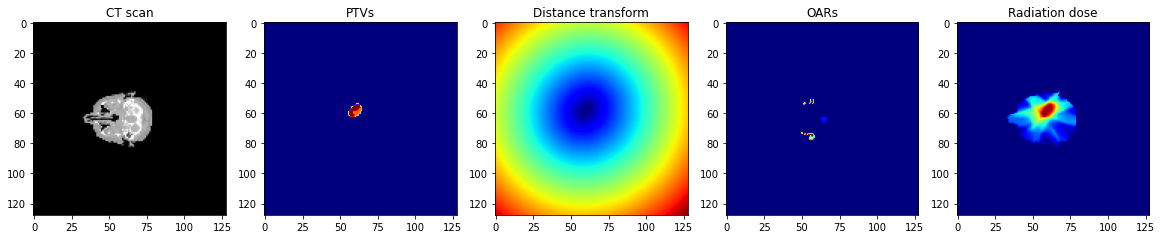

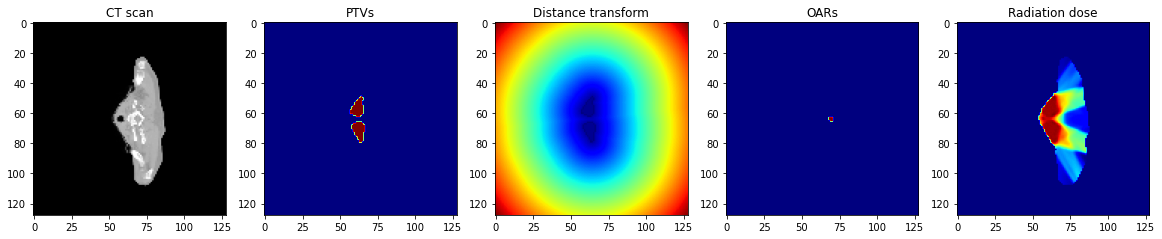

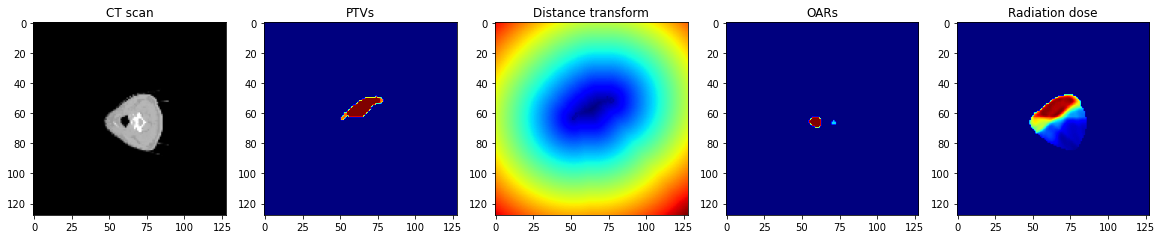

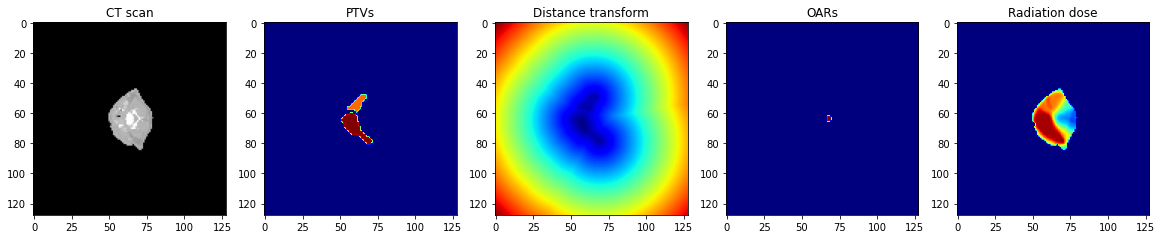

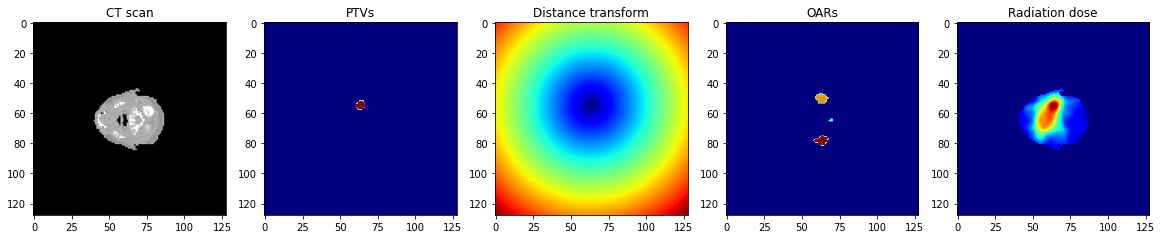

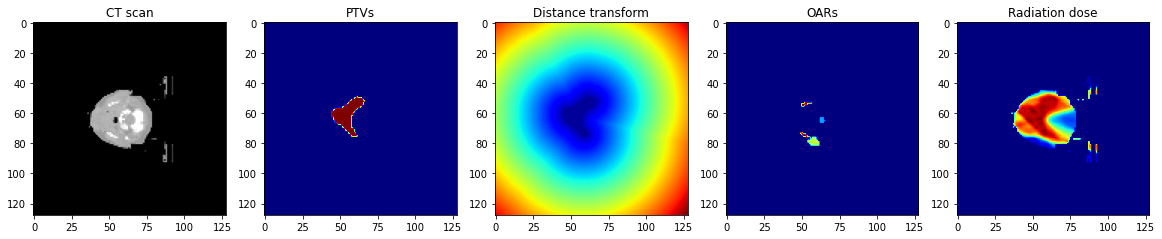

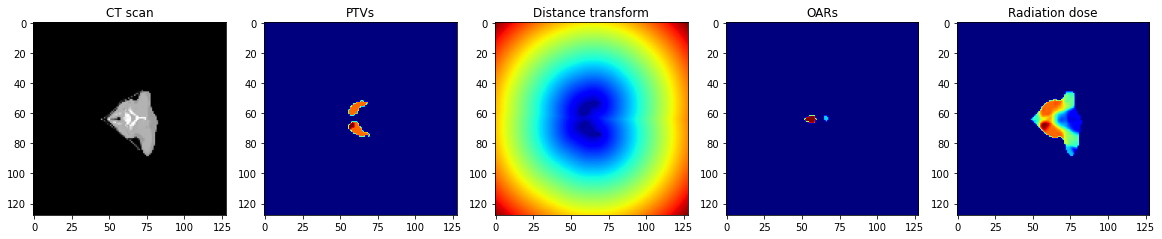

In [32]:
for batch_idx, list_loader_output in enumerate(val):
    show(list_loader_output[0]['data'])
    if batch_idx==10: break

### Data Duplication

In [39]:
def condition(b):
    return 'sample' in b and ('train' in b or 'val' in b)
    
train_val = [a[0] for a in os.walk('data/') if condition(a[0])]

In [40]:
d = read_all_data(train_val)

reading all the data


9000it [00:30, 293.59it/s]


In [41]:
samples, indices = np.unique(d, axis=0, return_index=True)

In [43]:
print(f'We have in our train and validation sets only {samples.shape[0]} unique images from {d.shape[0]}')

We have in our train and validation sets only 7124 unique images from 9000


In [ ]:
#we can use delete_duplication function to delete these duplications
delete_duplication(train_val) 

reading all the data


9000it [01:12, 124.85it/s]


Find unique samples
Deleting duplicated sampeles
1876 duplicated samples found


100%|██████████| 1876/1876 [00:02<00:00, 657.03it/s]


### Missing PTVs

In [54]:
data_paths = get_data_paths(dir)
missing_indices = missing_PTVs(data_paths, indices=False)
print(f'We have in our datasets {len(missing_indices)} samples with empty PTVs from {len(data_paths)}')

10200it [00:19, 536.54it/s]

We have in our datasets 831 samples with empty PTVs from 10200


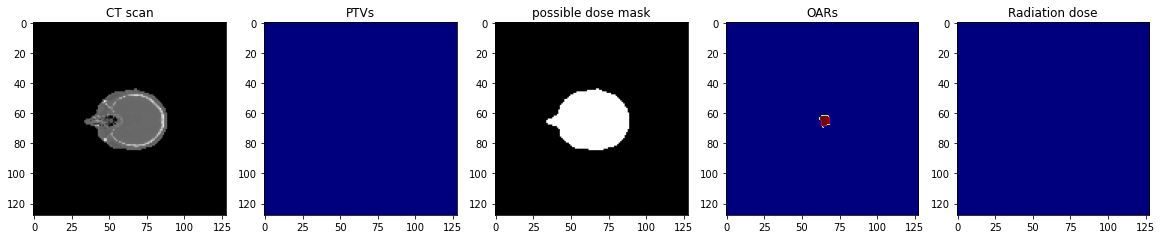

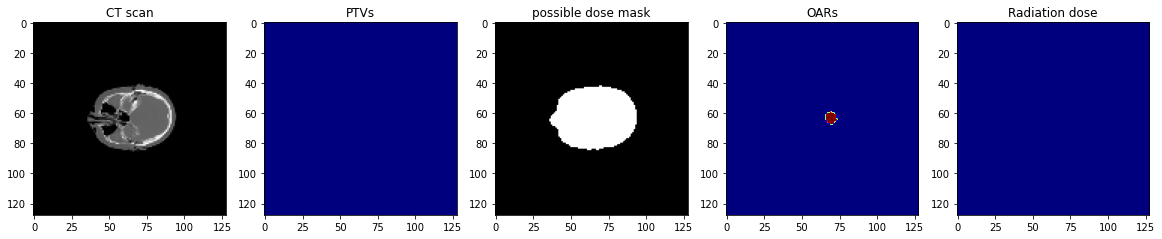

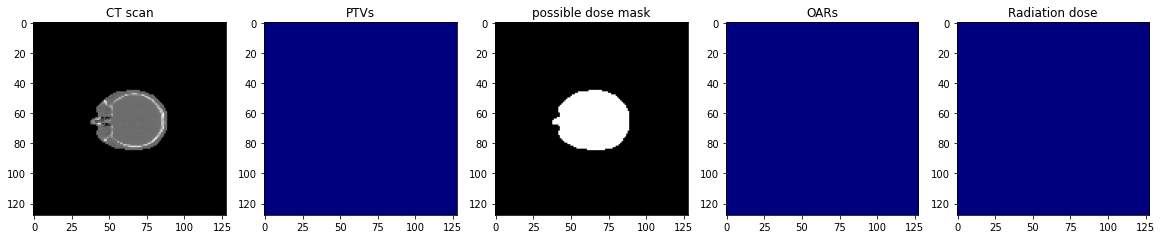

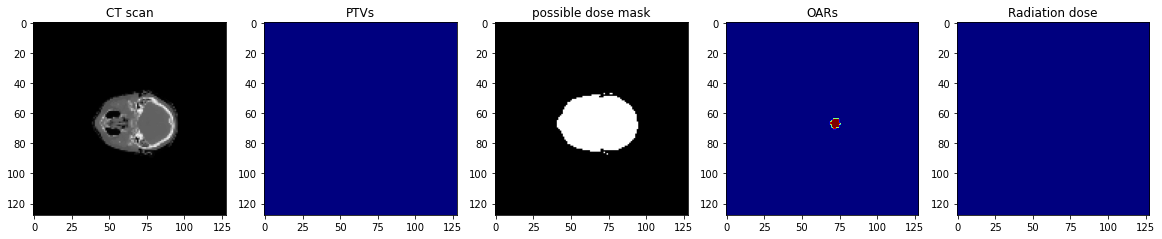

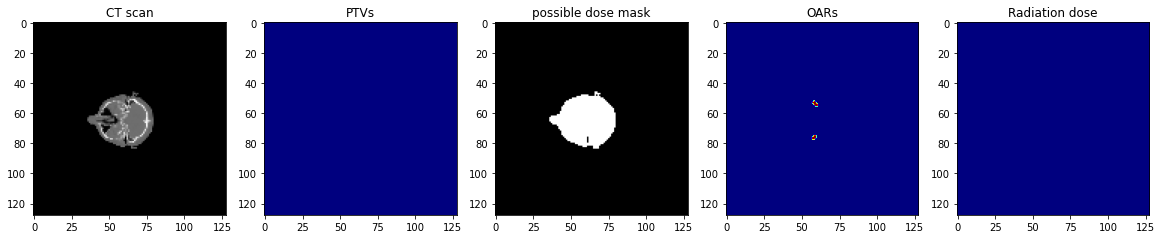

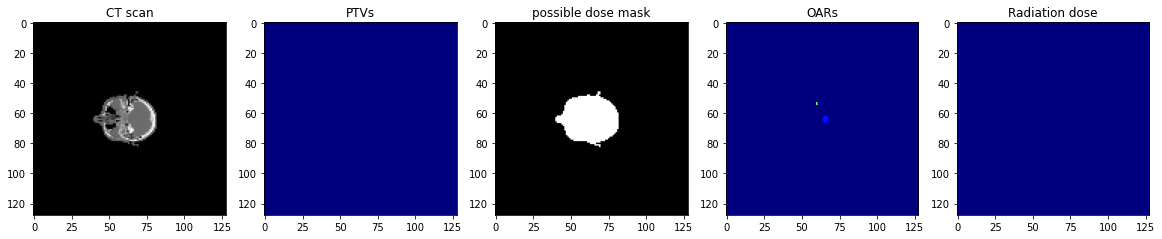

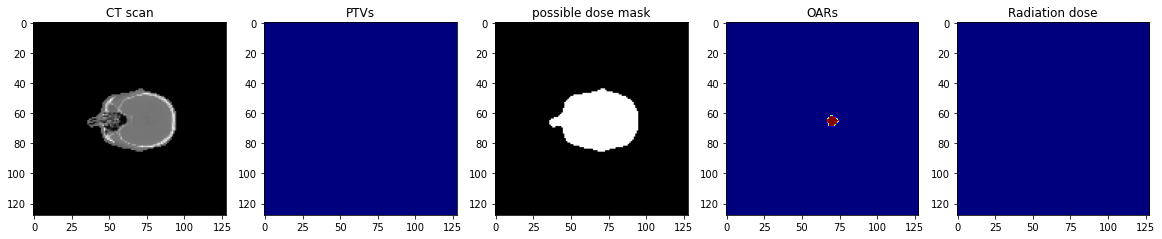

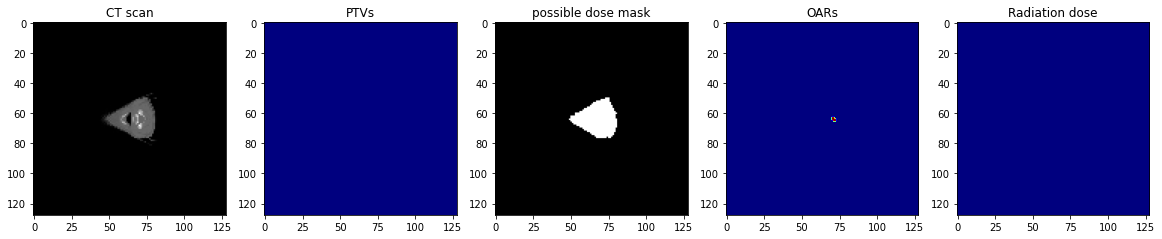

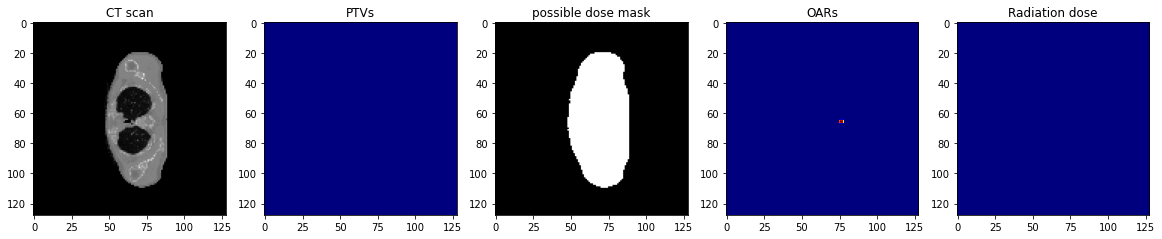

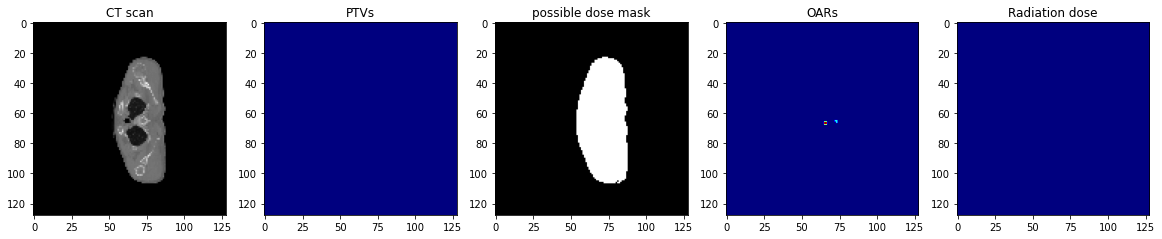

In [56]:
for p in missing_indices[:10]:
    if 'test' not in p:
        continue
    dict = read_data(p)
    CT_scan = dict[2]
    PTVs = dict[0]
    OARs = dict[1]
    Rdose = dict[-1]
    mask = dict[3]>0
    fig, axs = plt.subplots(ncols=5, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    
    axs[0, 0].set_title("CT scan")
    axs[0, 0].imshow(CT_scan, cmap='gray')
    #axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    axs[0, 1].set_title("PTVs")
    axs[0, 1].imshow(PTVs, cmap='jet')

    axs[0, 2].set_title("possible dose mask")
    axs[0, 2].imshow(mask, cmap='gray')

    axs[0, 3].set_title("OARs")
    axs[0, 3].imshow(OARs, cmap='jet')

    axs[0, 4].set_title("Radiation dose")
    axs[0, 4].imshow(Rdose, cmap='jet')
    plt.show()
    

#### Predict missing PTVs using CT scan and OARs

In [57]:
PATH = 'Output/DCNN_None_ROI_LOSS_ptv/best_val_evaluation_uloss.pkl'


train, val, test = get_loader('data', train_bs=32,
        val_bs=1,
        test_bs=1,
        train_num_samples_per_epoch=7800,  # 5000 iterations per epoch
        val_num_samples_per_epoch=1200,
        test_num_samples_per_epoch=1200,
        num_works=1,
        resplit=False,
        seed=199,#199
        with_miss_PTVs=True,
        with_distance=True,
        PTV_estimate=True
    )



In [58]:
path='Output/DCNN_None_ROI_LOSS_ptv1/best_val_evaluation_uloss.pkl'

model1 = Model(in_ch=2, out_ch=5,list_ch=[-1, 32, 64, 128, 256], PTV_estimator=True)
model1.load_state_dict(torch.load(path)['network_state_dict'])
model1 = model1.eval()

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


0it [00:00, ?it/s]

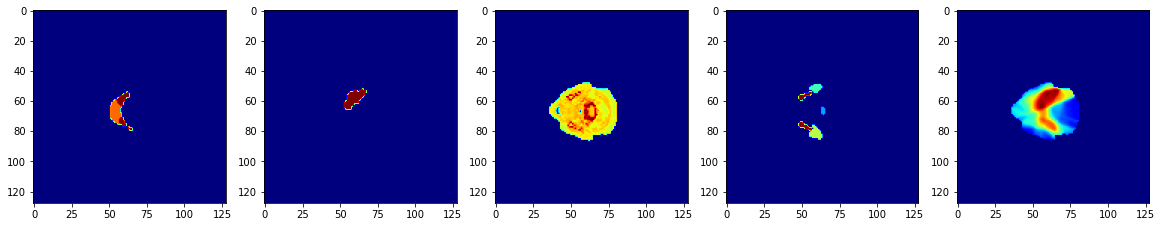

1it [00:00,  1.17it/s]

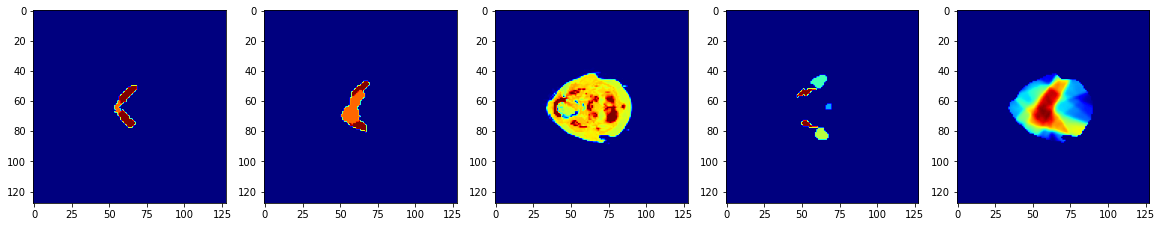

2it [00:01,  1.52it/s]

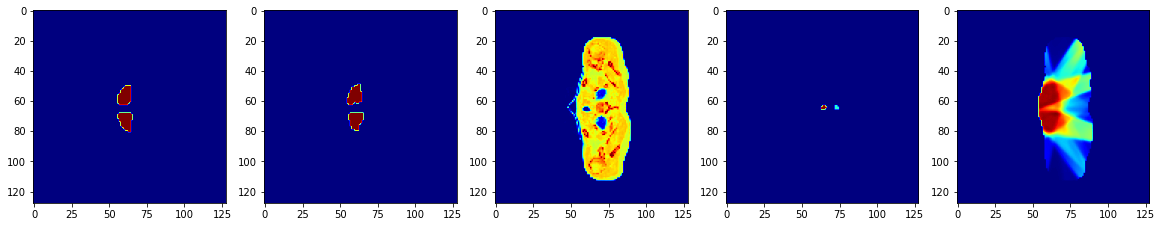

3it [00:01,  1.84it/s]

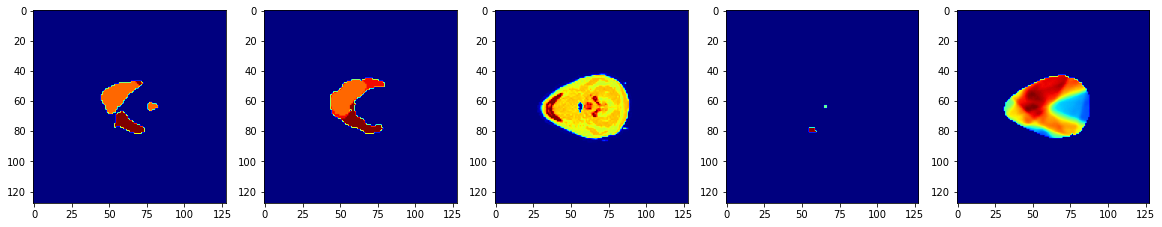

4it [00:02,  2.04it/s]

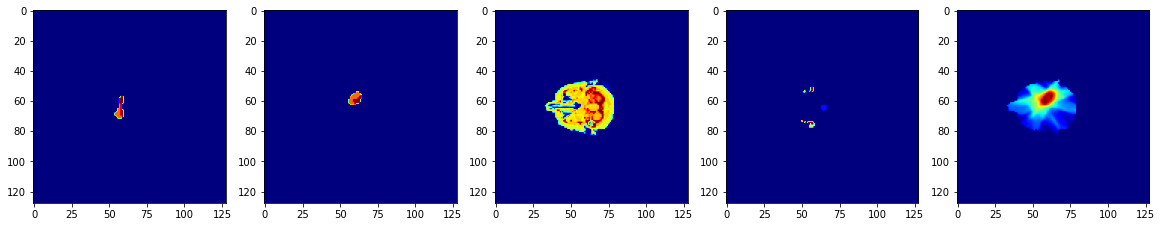

5it [00:02,  2.11it/s]

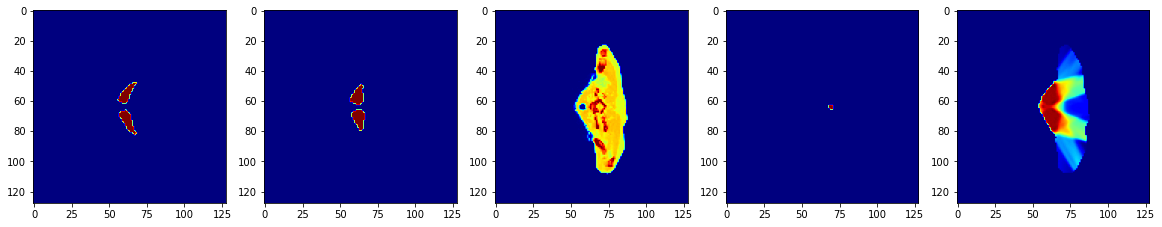

6it [00:03,  2.14it/s]

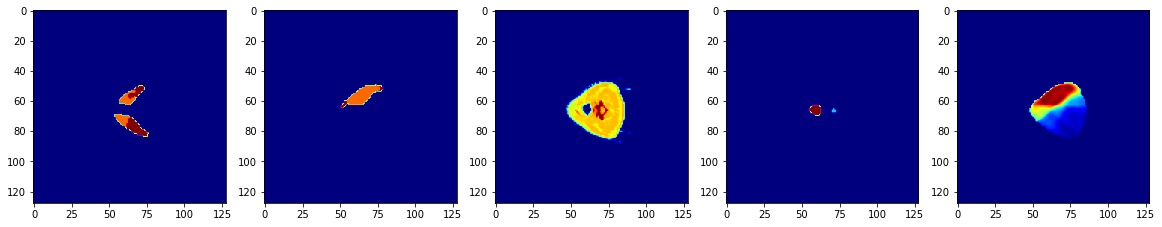

7it [00:03,  2.25it/s]

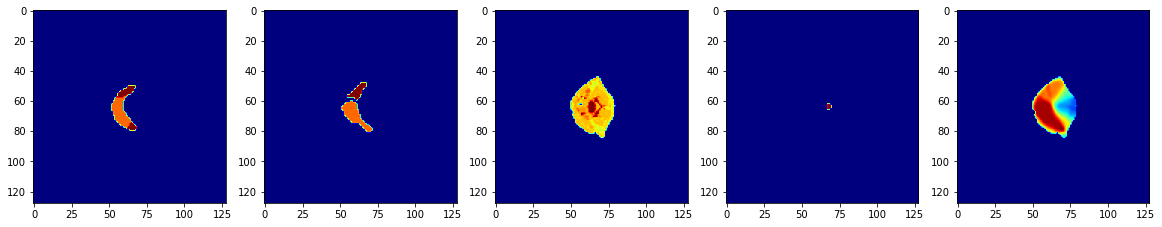

8it [00:04,  1.74it/s]

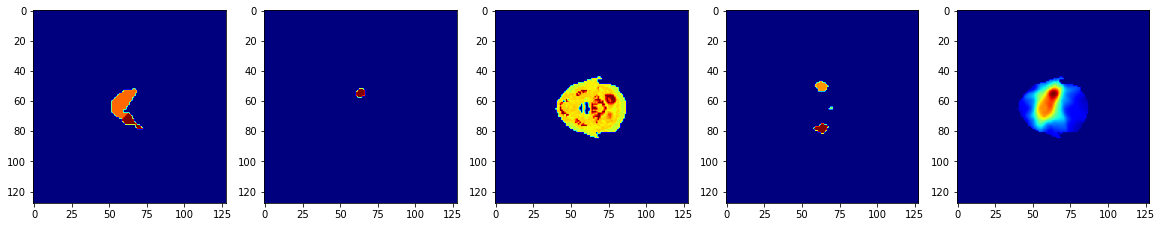

9it [00:04,  1.93it/s]

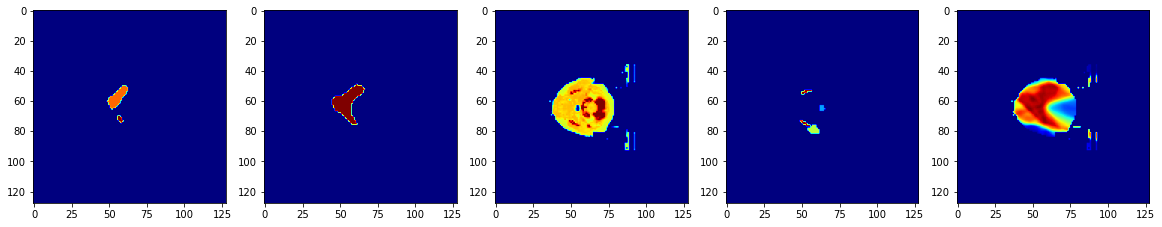

10it [00:05,  2.09it/s]

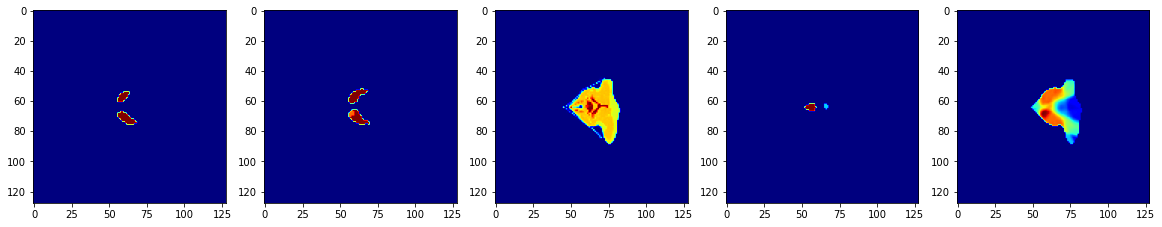

10it [00:05,  1.81it/s]


In [59]:


for batch_idx, list_loader_output in tqdm(enumerate(val)):
    # List_loader_output[0] default as the input
    path = list_loader_output[1][0]
    input_ = list_loader_output[0]['data'][0]
    target = list_loader_output[0]['data'][1][0]
    dose = list_loader_output[0]['data'][3][0]
    mask = list_loader_output[0]['data'][2][0][0]
    output = model1(input_)
    fig, axs = plt.subplots(ncols=5, squeeze=False)
    fig.set_figwidth(20)
    fig.set_figheight(20)
    output = (4-output[0].detach()[0].numpy().argmax(axis=0))
    output[output<=1] = 0
    ptv_pred = 1.*(output==4) + 63/70*(output==3) + 56/70*(output==2)
    ptv_gt = 1.*target[0] + 63/70*target[1] + 56/70*target[2]
    axs[0,0].imshow(ptv_pred*mask.detach().numpy(), cmap='jet')
    
    axs[0,1].imshow(ptv_gt, cmap='jet')
    
    axs[0,2].imshow(input_[0,0], cmap='jet')
    
    axs[0,3].imshow(input_[0,1], cmap='jet')

    axs[0,4].imshow(dose[0], cmap='jet')
    plt.show()
    if batch_idx>=10:
        break
    
    
    

### Test the trained models

#### Single Model

In [67]:
model_name = 'AUTOENC' #AUTOENC, DCNN, DCNN_2ENC
bottleneck = 'DFA' # NONE, Vit, DFA
without_distance = '' # _WD or empty 
loss = 'ROI_SM' # ROI, ROI_SM, L1
GAN = '' # GAN or empty


model_PATH = 'Output/' + model_name + '_' + GAN + '_' + bottleneck + '_' + loss + without_distance + '/best_val_evaluation_uloss.pkl'
PATH_OUT = 'Output/' + model_name + '_' + GAN + '_' + bottleneck + '_' + loss + without_distance + '/output'

if not os.path.exists(PATH_OUT):
    os.mkdir(PATH_OUT)


model1 = Model(in_ch=4, out_ch=1,list_ch=[-1, 32, 64, 128, 256], Unet=False)

model1.load_state_dict(torch.load(model_PATH)['network_state_dict'])
model1 = model1.eval()

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


#### Ensemble

In [45]:
paths=['Output/DCNN__DFA_ROI_SM/best_val_evaluation_uloss.pkl',
        'Output/DCNN__DFA_L1/best_val_evaluation_uloss.pkl',
        'Output/DCNN__Vit_ROI_SM/best_val_evaluation_uloss.pkl',
        'Output/DCNN_2ENC__DFA_ROI_SM/best_val_evaluation_uloss.pkl',
        'Output/DCNN_2ENC__DFA_ROI/best_val_evaluation_uloss.pkl',
        'Output/AUTOENC__DFA_ROI_SM/best_val_evaluation_uloss.pkl',
        ]
models=[]
model1 = Model(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256], bottleneck='DFA')
model2 = Model(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256], bottleneck='DFA')
model3 = Model(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256], bottleneck='Vit')
        
model4 = Model_sep(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256])
model5 = Model_sep(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256])
model6 = Model(in_ch=4, out_ch=1,
                                list_ch=[-1, 32, 64, 128, 256], Unet=False, bottleneck='DFA')

model1.load_state_dict(torch.load(paths[0])['network_state_dict'])
models.append(model1)
model2.load_state_dict(torch.load(paths[1])['network_state_dict'])
models.append(model2)
model3.load_state_dict(torch.load(paths[2])['network_state_dict'])
models.append(model3)
model4.load_state_dict(torch.load(paths[3])['network_state_dict'])
models.append(model4)
model5.load_state_dict(torch.load(paths[4])['network_state_dict'])
models.append(model5)
model6.load_state_dict(torch.load(paths[5])['network_state_dict'])
models.append(model6)

# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !
# random init encoder weight using nn.init.kaiming_uniform !
# random init decoder weight using nn.init.kaiming_uniform !


In [46]:
PATH_OUT = 'Output/ENSEMBLE/output'
model = Ensemble(models)

### Validation

In [47]:
_, val, test = get_loader('data', train_bs=32,
        val_bs=1,
        test_bs=1,
        train_num_samples_per_epoch=7800,  # 5000 iterations per epoch
        val_num_samples_per_epoch=1200,
        test_num_samples_per_epoch=1200,
        num_works=1,
        resplit=False,
        seed=199,#199
        with_miss_PTVs=True,
        with_distance=True
    )

0it [00:00, ?it/s]

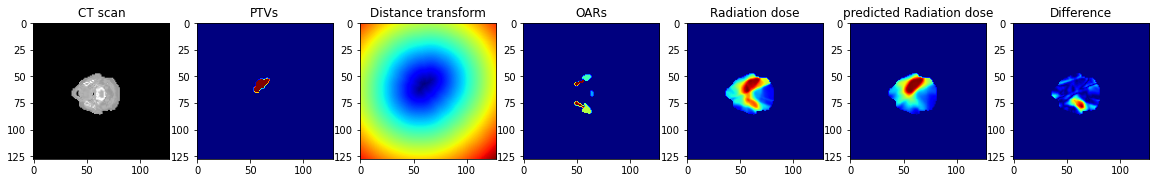

1it [00:01,  1.04s/it]

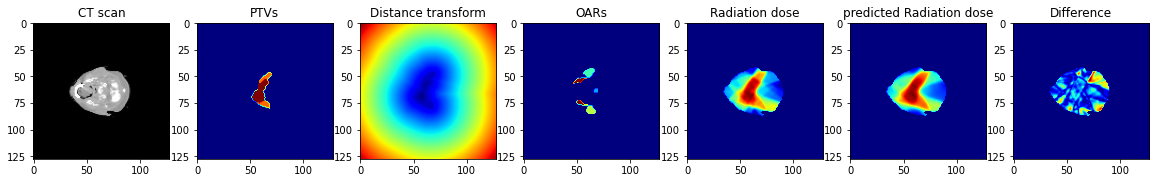

2it [00:01,  1.26it/s]

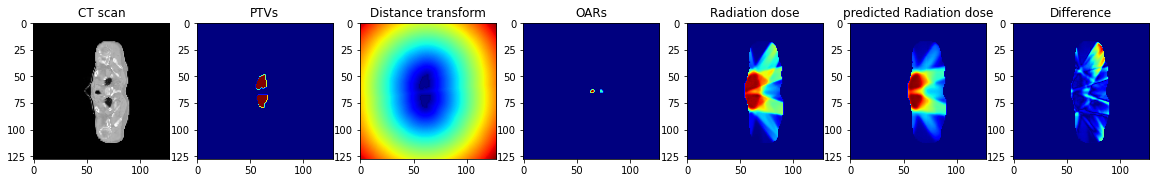

3it [00:02,  1.43it/s]

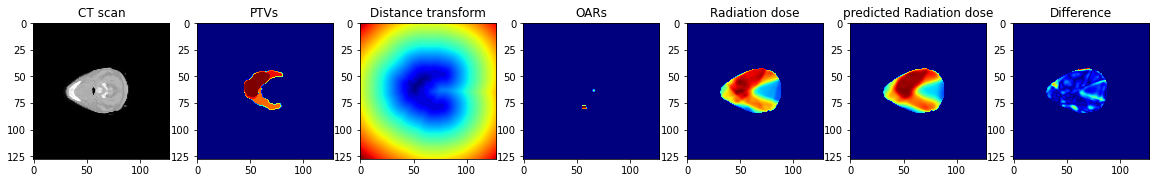

4it [00:03,  1.18it/s]

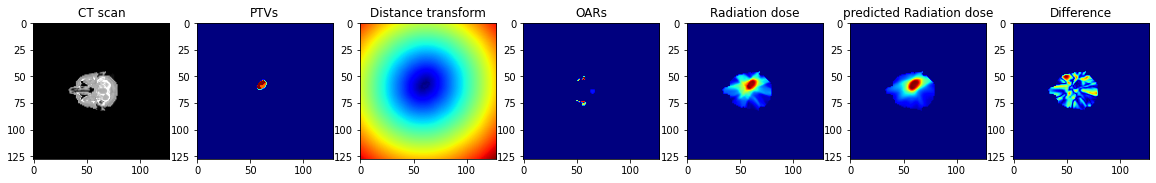

1200it [04:26,  4.51it/s]


In [48]:
from DCNN.loss import L1Loss

loss_artif = []
loss = []
Visualize = True

loss_fn= L1Loss()

for batch_idx, list_loader_output in tqdm(enumerate(val)):
    # List_loader_output[0] default as the input
    path = list_loader_output[1][0]
    input_ = list_loader_output[0]['data'][0]
    target = list_loader_output[0]['data'][1][0][0]
    mask = list_loader_output[0]['data'][2][0][0]
    if input_[0][0].sum()!=0:
        output = model(input_)
        loss.append(float(loss_fn(output, [target, mask])))
        if batch_idx<5 and Visualize:
            show(list_loader_output[0]['data'], output[0].detach()*mask)
            
    else:
        output = model(input_)
        loss_artif.append(float(loss_fn(output, [target, mask])))
        if batch_idx<5 and Visualize:
            show(list_loader_output[0]['data'], output[0].detach()[0]*mask)

    

In [65]:
print(f'MAE of the predicted radiation dose in the validation set: %.4f' %np.mean(loss+loss_artif))

MAE of the predicted radiation dose in the validation set: 0.3775


In [30]:
#Ensemble
print(f'MAE of the predicted radiation dose in the validation set: %.4f' %np.mean(loss+loss_artif))
np.mean(loss), np.mean(loss_artif), np.mean(loss_artif+loss)

MAE of the predicted radiation dose in the validation set: 0.3536


(0.3458851922370402, 0.4105654338250992, 0.35359292102628387)

In [31]:
print(f'MAE of the predicted radiation dose in the validation set: %.4f' %np.mean(loss+loss_artif))

MAE of the predicted radiation dose in the validation set: 0.3816


In [66]:
np.mean(loss), np.mean(loss_artif), np.mean(loss_artif+loss)

(0.37201602233956194, 0.4184030385336259, 0.3775438084360212)

In [30]:
np.mean(loss), np.mean(loss_artif), np.mean(loss_artif+loss)

(0.3739786023977182, 0.43754265328439385, 0.3815533184617137)

### Testing

In [39]:
loss = []
loss_fn= nn.L1Loss(reduction='mean')

for batch_idx, list_loader_output in tqdm(enumerate(test)):
    path = list_loader_output[1][0]
    input_ = list_loader_output[0][0]
    target = list_loader_output[0][1][0,0]
    mask = list_loader_output[0][2][0][0]
    if input_[0][0].sum()!=0:
        output = model(input_)
        img_pred = (output[0]*mask).detach().numpy()
    else:
        output = model(input_)
        img_pred = (output[0]*mask).detach().numpy()
    
    np.save(PATH_OUT + '/' + path.split('/')[-1], img_pred)       
     

1200it [05:02,  3.97it/s]
